In [1]:
import pandas as pd
import numpy as np
import tensorflow

In [2]:
from tensorflow import keras

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [4]:
from matplotlib import pyplot

In [5]:
from pandas import read_csv
from pandas import DataFrame

In [6]:
import os
PATH = "../data/clean_data"
dataset = pd.read_csv('../data/clean_data/KNMI_20200607.csv', header=0, index_col=0)

print("Starting file:")
print(dataset[0:10])

print("Ending file:")
print(dataset[-10:])

df_backup = dataset


Starting file:
      YYYYMMDD  DDVEC  FHVEC     FG    FHX   FHXH    FHN   FHNH    FXX   FXXH  \
 STN                                                                            
260   19010601                                                                  
260   19010602                                                                  
260   19010603                                                                  
260   19010604                                                                  
260   19010605                                                                  
260   19010606                                                                  
260   19010607                                                                  
260   19010608                                                                  
260   19010609                                                                  
260   19010610                                                                  

      ...   

/home/lawrencefulton/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7,8,13,15,16,18,19,20,21,22,23,25,26,28,30,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df = df_backup
df['TG'] = df['TG'].astype(float)
df['YYYYMMDD'] = pd.to_datetime(df['YYYYMMDD'], 
                                 format='%Y%m%d')


print(df.head())

df['Year'] = df['YYYYMMDD'].dt.year
df['Month'] = df['YYYYMMDD'].dt.month
df['Day'] = df['YYYYMMDD'].dt.day
print(df[-5:])


df_train = df[df['Year']<2000]
df_test = df[df['Year']>=2000]

temp_train = df_train['TG'].tolist()
temp_test = df_test['TG'].tolist()


print("Training set has {} observations.".format(len(temp_train)))
print("Test set has {} observations.".format(len(temp_test)))

       YYYYMMDD  DDVEC  FHVEC     FG    FHX   FHXH    FHN   FHNH    FXX  \
 STN                                                                      
260  1901-06-01                                                           
260  1901-06-02                                                           
260  1901-06-03                                                           
260  1901-06-04                                                           
260  1901-06-05                                                           

       FXXH  ...   VVNH    VVX   VVXH     NG    UG     UX    UXH     UN  \
 STN         ...                                                          
260          ...                                81                        
260          ...                                78                        
260          ...                                80                        
260          ...                                74                        
260          ...        

In [10]:
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [15]:

SEQUENCE_SIZE = 10
train_X, train_Y = to_sequences(SEQUENCE_SIZE,temp_train)
test_X, test_Y = to_sequences(SEQUENCE_SIZE,temp_test)



print("Shape of training set: {}".format(train_X.shape))
print("Shape of test set: {}".format(test_X.shape))

Shape of training set: (35998, 10, 1)
Shape of test set: (7454, 10, 1)


6000 days with each 30 variables trying to predict 1 variable times 6000. This Is then used on the test dataset where one has 1438 days * 30 variables again to predict 1 variable, which determins the quility of the LSTM

Train on 35998 samples, validate on 7454 samples
Epoch 1/1000
35998/35998 - 15s - loss: 1498.5262 - val_loss: 396.6862
Epoch 2/1000
35998/35998 - 13s - loss: 378.4758 - val_loss: 394.3162
Epoch 3/1000
35998/35998 - 15s - loss: 377.2361 - val_loss: 388.8882
Epoch 4/1000
35998/35998 - 13s - loss: 373.7598 - val_loss: 408.3327
Epoch 5/1000
35998/35998 - 16s - loss: 374.8103 - val_loss: 381.6218
Epoch 6/1000
35998/35998 - 18s - loss: 372.8949 - val_loss: 384.7406
Epoch 7/1000
35998/35998 - 15s - loss: 372.6744 - val_loss: 395.6191
Epoch 8/1000
35998/35998 - 13s - loss: 372.1049 - val_loss: 382.7819
Epoch 9/1000
35998/35998 - 15s - loss: 372.2103 - val_loss: 384.8555
Epoch 10/1000
Restoring model weights from the end of the best epoch.
35998/35998 - 17s - loss: 372.5909 - val_loss: 390.0335
Epoch 00010: early stopping


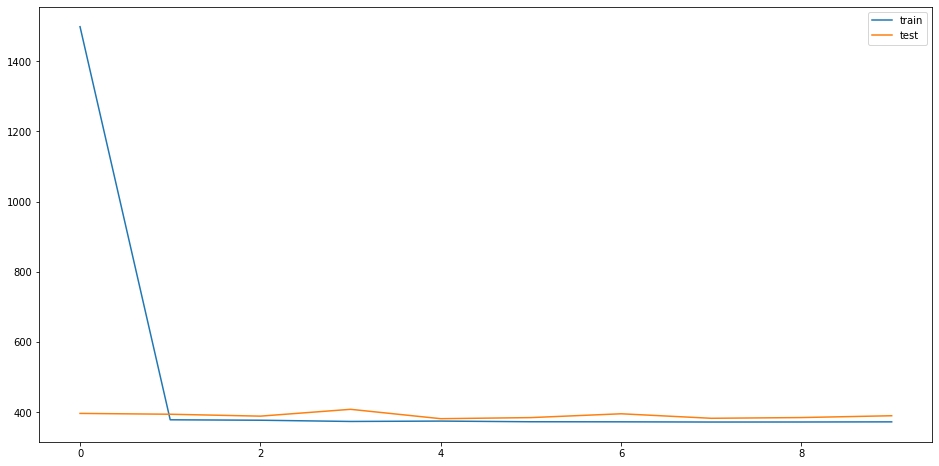

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# design network
model = Sequential()
model.add(LSTM(64,dropout=0.0, recurrent_dropout=0.0, input_shape=(None, 1)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)

# fit network
history = model.fit(train_X,train_Y,validation_data=(test_X,test_Y),
          callbacks=[monitor],verbose=2,epochs=1000)
# plot history
pyplot.figure(figsize=(16,8))       # Increase the size of the plot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Model evaluation

In [17]:
from sklearn import metrics

pred = model.predict(test_X)
score = np.sqrt(metrics.mean_squared_error(pred,test_Y))
print("Score (RMSE): {}".format(score))

Score (RMSE): 19.535141851856636
